chow test 이외의 방법을 적용하여서 비교보아도 GPT전/후의 차이를 보이는지 확인 

t-test와 mann-whitney방법 적용 

In [1]:
import sys, os
p = os.path.abspath('..')
pp = os.path.abspath('../..')
sys.path.insert(1, p)
sys.path.insert(1, pp)
import config.config as conf
import pickle
from scipy.stats import levene, ttest_ind
import datetime 
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

1.3 독립표본 t-검정 (paired sample t-test)¶  
 
두개의 독립된 모집단의 평균을 비교하고자 할 때 사용하는 검정
두 개의 모집단에서 크기가 n개인 표본을 각각 추출한 후 표본의 관측값들을 이용해 검정을 실시. 따라서 독립표본 t검정에서는 모집단, 모수, 표본이 모두 두개씩 존재.
두 모집단은 정규성을 만족해야한다. 표본의 크기가 충분히 크다면 중심극한정리에 따라 정규성을 만족한다고 볼 수 있다. / 두개의 모집단은 서로 독립적이어야 한다. / 두 모집단의 분산이 서로 같음을 의미하는 등분산성 가정을 만족해야한다 (등분산성 가정은 두 독립집단의 모분산이 동일해야함을 의미)/ 독립변수는 범주형, 종속변수는 연속형이어야 한다.
부부100쌍을 뽑아 남편 100명과 아내 100명으로 집단 비교하는 경우는 대응표본/ 무작위로 남자 100명 여자 100명을 뽑아 두 집단을 비교하는 경우는 독립표본

In [2]:
with open(f'{conf.DATA_PATH}/data/cc_python_raw_df.pkl', 'rb') as f:
    calc_ed_com_df = pickle.load(f)

In [3]:
calc_ed_com_df['cdate'] = pd.to_datetime(calc_ed_com_df['cdate'])

In [4]:
calc_ed_com_df.loc[:,  'rel_days'] = (calc_ed_com_df.loc[:,  'cdate'] - datetime.datetime(2022,11,30)).dt.days

In [5]:
with open(f'{conf.DATA_PATH}/data/cc_python_chow_df.pkl', 'rb') as f:
    chow_df = pickle.load(f)

In [6]:
with open(f'{conf.DATA_PATH}/data/m_chk_cnt_0.pkl', 'rb') as f:
    m_chk_cnt_0 = pickle.load(f)

In [7]:
with open(f'{conf.DATA_PATH}/data/m_chk_cnt_1.pkl', 'rb') as f:
    m_chk_cnt_1 = pickle.load(f)

In [8]:
with open(f'{conf.DATA_PATH}/data/m_chk_cnt_2.pkl', 'rb') as f:
    m_chk_cnt_2 = pickle.load(f)

In [9]:
def ttest_simulation(df, iv, max_diff_day):
    return_df = pd.DataFrame()

    for i in range(30, 30+max_diff_day):
        af_df = df[(df['rel_days']>=0) & (df['rel_days'] <0+i)  ]
        bf_df = df[(df['rel_days'] <0) & (df['rel_days']>=0-i)  ]

        if levene(bf_df[iv],af_df[iv]).pvalue >=0.05 :
            pvalue = ttest_ind(bf_df[iv],af_df[iv], equal_var=False).pvalue
        else : 
            pvalue = ttest_ind(bf_df[iv],af_df[iv]).pvalue

        n_rows = pd.DataFrame({'diff_day': [i], 'pvalue': [float(f'{pvalue:0.3f}')]})
        return_df = pd.concat([return_df, n_rows], axis = 0).reset_index(drop=True)

    return return_df


In [10]:
def mann_simulation(df, iv, max_diff_day):
    return_df = pd.DataFrame()

    for i in range(30, 30+max_diff_day):
        af_df = df[(df['rel_days']>=0) & (df['rel_days'] <0+i)  ]
        bf_df = df[(df['rel_days'] <0) & (df['rel_days']>=0-i)  ]

        stat, p = mannwhitneyu(af_df[iv], bf_df[iv])

        n_rows = pd.DataFrame({'diff_day': [i], 'pvalue': [float(f'{p:0.3f}')]})
        return_df = pd.concat([return_df, n_rows], axis = 0).reset_index(drop=True)

    return return_df


In [11]:
chow_p_tdf              = ttest_simulation(chow_df,'Cognitive Complexity',  270)
calc_ed_com_df_p_tdf    = ttest_simulation(calc_ed_com_df,'Cognitive Complexity',270)

chow_p_mdf              = mann_simulation(chow_df,'Cognitive Complexity',  270)
calc_ed_com_df_p_mdf    = mann_simulation(calc_ed_com_df,'Cognitive Complexity',270)


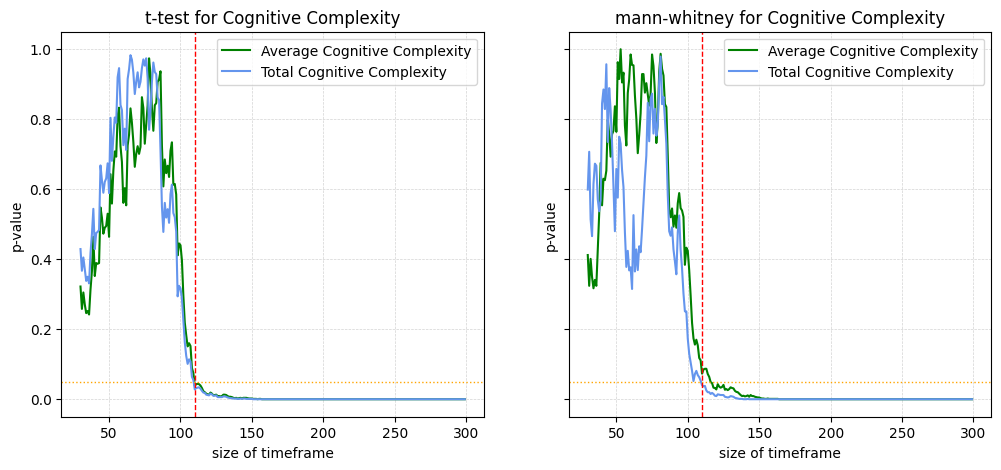

In [25]:
### create a figure with multiple subplots
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False

fig, axs = plt.subplots(1, 2, figsize = (12, 5), sharey=sharey, sharex=sharex)


axs[0].plot(chow_p_tdf['diff_day'], chow_p_tdf['pvalue'], label="Average Cognitive Complexity", color="green") 
axs[0].plot(calc_ed_com_df_p_tdf['diff_day'], calc_ed_com_df_p_tdf['pvalue'], label="Total Cognitive Complexity", color="CornflowerBlue")  
axs[0].set_xlabel('size of timeframe')
axs[0].set_ylabel('p-value')
axs[0].axhline(0.05, color='orange', linestyle=':', linewidth=1)
axs[0].axvline(110, color='red', linestyle='--', linewidth=1)
axs[0].set_title('t-test for Cognitive Complexity')
axs[0].grid(color='lightgray', linestyle = '--', linewidth = 0.5)
axs[0].legend()


axs[1].plot(chow_p_mdf['diff_day'], chow_p_mdf['pvalue'], label="Average Cognitive Complexity", color="green") 
axs[1].plot(calc_ed_com_df_p_mdf['diff_day'], calc_ed_com_df_p_mdf['pvalue'], label="Total Cognitive Complexity", color="CornflowerBlue")  
axs[1].set_xlabel('size of timeframe')
axs[1].set_ylabel('p-value')
axs[1].axhline(0.05, color='orange', linestyle=':', linewidth=1)
axs[1].axvline(110, color='red', linestyle='--', linewidth=1)
axs[1].set_title('mann-whitney for Cognitive Complexity')
axs[1].grid(color='lightgray', linestyle = '--', linewidth = 0.5)
axs[1].legend()

plt.show();



In [20]:
m_chk_cnt_0_p_tdf = ttest_simulation(m_chk_cnt_0,    'rate',     270)
m_chk_cnt_1_p_tdf = ttest_simulation(m_chk_cnt_1,    'rate',     270)
m_chk_cnt_2_p_tdf = ttest_simulation(m_chk_cnt_2,    'rate',     270)


m_chk_cnt_0_p_mdf = mann_simulation(m_chk_cnt_0,    'rate',     270)
m_chk_cnt_1_p_mdf = mann_simulation(m_chk_cnt_1,    'rate',     270)
m_chk_cnt_2_p_mdf = mann_simulation(m_chk_cnt_2,    'rate',     270)


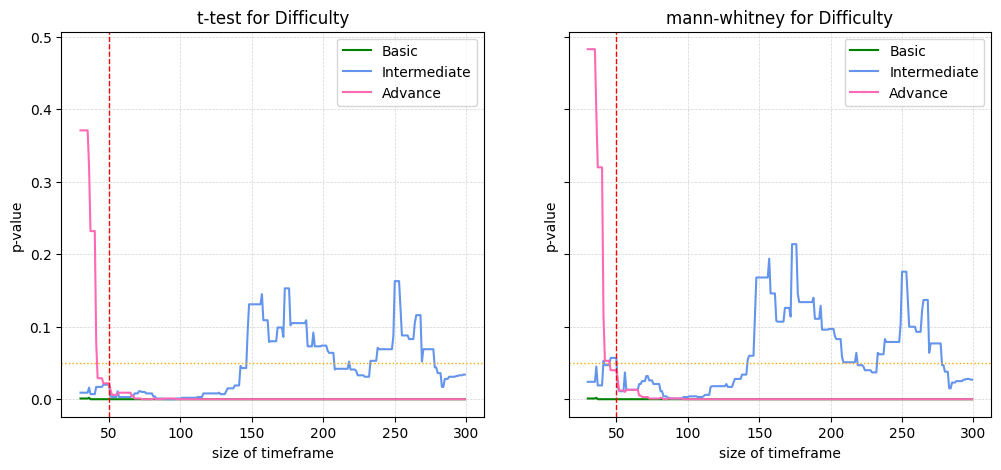

In [28]:
### create a figure with multiple subplots
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False

fig, axs = plt.subplots(1, 2, figsize = (12, 5), sharey=sharey, sharex=sharex)


axs[0].plot(m_chk_cnt_0_p_tdf['diff_day'], m_chk_cnt_0_p_tdf['pvalue'], label="Basic", color="green") 
axs[0].plot(m_chk_cnt_1_p_tdf['diff_day'], m_chk_cnt_1_p_tdf['pvalue'], label="Intermediate", color="CornflowerBlue")  
axs[0].plot(m_chk_cnt_2_p_tdf['diff_day'], m_chk_cnt_2_p_tdf['pvalue'], label="Advance", color="hotpink")  
axs[0].set_xlabel('size of timeframe')
axs[0].set_ylabel('p-value')
axs[0].axhline(0.05, color='orange', linestyle=':', linewidth=1)
axs[0].axvline(50, color='red', linestyle='--', linewidth=1)
axs[0].set_title('t-test for Difficulty')
axs[0].grid(color='lightgray', linestyle = '--', linewidth = 0.5)
axs[0].legend()

axs[1].plot(m_chk_cnt_0_p_mdf['diff_day'], m_chk_cnt_0_p_mdf['pvalue'], label="Basic", color="green") 
axs[1].plot(m_chk_cnt_1_p_mdf['diff_day'], m_chk_cnt_1_p_mdf['pvalue'], label="Intermediate", color="CornflowerBlue")  
axs[1].plot(m_chk_cnt_2_p_mdf['diff_day'], m_chk_cnt_2_p_mdf['pvalue'], label="Advance", color="hotpink")
axs[1].set_xlabel('size of timeframe')
axs[1].set_ylabel('p-value')
axs[1].axhline(0.05, color='orange', linestyle=':', linewidth=1)
axs[1].axvline(50, color='red', linestyle='--', linewidth=1)
axs[1].set_title('mann-whitney for Difficulty')
axs[1].grid(color='lightgray', linestyle = '--', linewidth = 0.5)
axs[1].legend()

plt.show();

In [18]:

af_df = chow_df[(chow_df['rel_days']>=0) & (chow_df['rel_days'] <0+110)  ]
bf_df = chow_df[(chow_df['rel_days'] <0) & (chow_df['rel_days']>=0-110)  ]



In [ ]:
bf_df['Cognitive Complexity'].std()

In [ ]:
np.mean(af_df['Cognitive Complexity'])

In [ ]:
ttest_ind(bf_df['Cognitive Complexity'],af_df['Cognitive Complexity']).pvalue

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 생성
groups = ['Before', 'After']
means = [np.mean(bf_df['Cognitive Complexity']), np.mean(af_df['Cognitive Complexity'])]  # 그룹 평균
std_devs = [bf_df['Cognitive Complexity'].std(), af_df['Cognitive Complexity'].std()]  # 그룹 표준편차 (또는 표준오차)

# 그래프 그리기
plt.figure(figsize=(6, 4))

# 평균값과 에러바 추가
plt.errorbar(groups, means, yerr=std_devs, fmt='o-', color='black', ecolor='black', capsize=5, elinewidth=1.2, markerfacecolor='white', markersize=8)

# 축 및 라벨 설정
plt.xlabel('Group', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.ylim(14, 22)  # Y축 범위 설정
plt.grid(True, linestyle='--', alpha=0.6)

# 레이아웃 조정 및 저장
plt.tight_layout()
plt.savefig('lineplot_with_errorbars.png', dpi=300, bbox_inches='tight')  # 논문용으로 저장
plt.show()


In [23]:

af_df = calc_ed_com_df[(calc_ed_com_df['rel_days']>=0) & (calc_ed_com_df['rel_days'] <0+200)  ]
bf_df = calc_ed_com_df[(calc_ed_com_df['rel_days'] <0) & (calc_ed_com_df['rel_days']>=0-200)  ]

In [ ]:
from scipy.stats import mannwhitneyu

group1 = af_df['Cognitive Complexity']
group2 = bf_df['Cognitive Complexity']

stat, p = mannwhitneyu(group1, group2)
print(f"Mann-Whitney U test: statistic={stat}, p-value={p}")

In [ ]:
group2 = af_df[['Cognitive Complexity']]
group2['Group'] = 'After'
group1 = bf_df[['Cognitive Complexity']]
group1['Group'] = 'Before'


In [26]:
df = pd.concat([group1, group2], axis = 0).reset_index(drop=True)
df['Complexity_log'] = np.log(df['Cognitive Complexity'] + 1) 

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 박스플롯 생성
plt.figure(figsize=(8, 6))
# sns.boxplot(data=df, x='Group', y='Cognitive Complexity', palette="Set2", width=0.6)
# sns.stripplot(data=df, x='Group', y='Cognitive Complexity', color='black', alpha=0.5, jitter=True)

sns.boxplot(data=df, x='Group', y='Complexity_log', hue='Group',palette="Set2", width=0.6)
sns.stripplot(data=df, x='Group', y='Complexity_log', color='black', alpha=0.5, jitter=True)

# p-value 추가
stat, p = mannwhitneyu(group1['Cognitive Complexity'], group2['Cognitive Complexity'])
plt.text(0.5, max(df['Complexity_log']) + 2, f'p = {p:.3f}', ha='center', fontsize=12)

# 축 및 제목 설정
plt.xlabel('Group', fontsize=12)
plt.ylabel('Code Complexity', fontsize=12)
plt.title('Mann-Whitney U Test Results', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("mann_whitney_plot.png", dpi=300, bbox_inches='tight')
plt.show()


NameError: name 'df' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 생성
groups = ['Before', 'After']
means = [np.mean(bf_df['Cognitive Complexity']), np.mean(af_df['Cognitive Complexity'])]  # 그룹 평균
std_devs = [bf_df['Cognitive Complexity'].std(), af_df['Cognitive Complexity'].std()]  # 그룹 표준편차 (또는 표준오차)

# 그래프 그리기
plt.figure(figsize=(6, 4))

# 평균값과 에러바 추가
plt.errorbar(groups, means, yerr=std_devs, fmt='o-', color='black', ecolor='black', capsize=5, elinewidth=1.2, markerfacecolor='white', markersize=8)

# 축 및 라벨 설정
plt.xlabel('Group', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.ylim(14, 22)  # Y축 범위 설정
plt.grid(True, linestyle='--', alpha=0.6)

# 레이아웃 조정 및 저장
plt.tight_layout()
plt.savefig('lineplot_with_errorbars.png', dpi=300, bbox_inches='tight')  # 논문용으로 저장
plt.show()


In [ ]:
m_chk_cnt_0

In [30]:

af_df = m_chk_cnt_0[(m_chk_cnt_0['rel_days']>=0) & (m_chk_cnt_0['rel_days'] <0+50)  ]
bf_df = m_chk_cnt_0[(m_chk_cnt_0['rel_days'] <0) & (m_chk_cnt_0['rel_days']>=0-50)  ]

In [ ]:
from scipy.stats import mannwhitneyu

group1 = af_df['rate']
group2 = bf_df['rate']

stat, p = mannwhitneyu(group1, group2)
print(f"Mann-Whitney U test: statistic={stat}, p-value={p}")

In [ ]:
group2 = af_df[['rate']]
group2['Group'] = 'After'
group1 = bf_df[['rate']]
group1['Group'] = 'Before'


In [33]:
df = pd.concat([group1, group2], axis = 0).reset_index(drop=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 생성
groups = ['Before', 'After']
means = [np.mean(bf_df['rate']), np.mean(af_df['rate'])]  # 그룹 평균
std_devs = [bf_df['rate'].std(), af_df['rate'].std()]  # 그룹 표준편차 (또는 표준오차)

# 그래프 그리기
plt.figure(figsize=(6, 4))

# 평균값과 에러바 추가
plt.errorbar(groups, means, yerr=std_devs, fmt='o-', color='black', ecolor='black', capsize=5, elinewidth=1.2, markerfacecolor='white', markersize=8)

# 축 및 라벨 설정
plt.xlabel('Group', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.ylim(14, 22)  # Y축 범위 설정
plt.grid(True, linestyle='--', alpha=0.6)

# 레이아웃 조정 및 저장
plt.tight_layout()
plt.savefig('lineplot_with_errorbars.png', dpi=300, bbox_inches='tight')  # 논문용으로 저장
plt.show()
